In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import glob

**5.1 Data Preparation**

In [3]:
# List all filename in face image path
filenames = glob.glob('face_mini/**/*.jpg', recursive=True)

# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
# Convert the image to an array
# Normalized color image
all_images = []
for i in filenames:
    img = image.load_img(i, target_size=(100,100,3), interpolation="nearest")
    img = image.img_to_array(img)
    img = img / 255
    all_images.append(img)

# Convert to numpy array
all_images = np.array(all_images)
print(all_images.shape)

# split data into train and validation data
train_x, test_x = train_test_split(all_images, random_state=32, test_size=0.3)
train_x, val_x = train_test_split(train_x, random_state=32, test_size=0.3)


(3203, 100, 100, 3)


**5.2 ADD Noise**

In [4]:
# Add Noise
#   Scala between 0-1
noise_factor = 0.2 # 0-1

# กำหนด noise parameter
Nmean = 0
Nstd = 1

# Use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape))

x_val_noisy = val_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape))

x_test_noisy = test_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=test_x.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


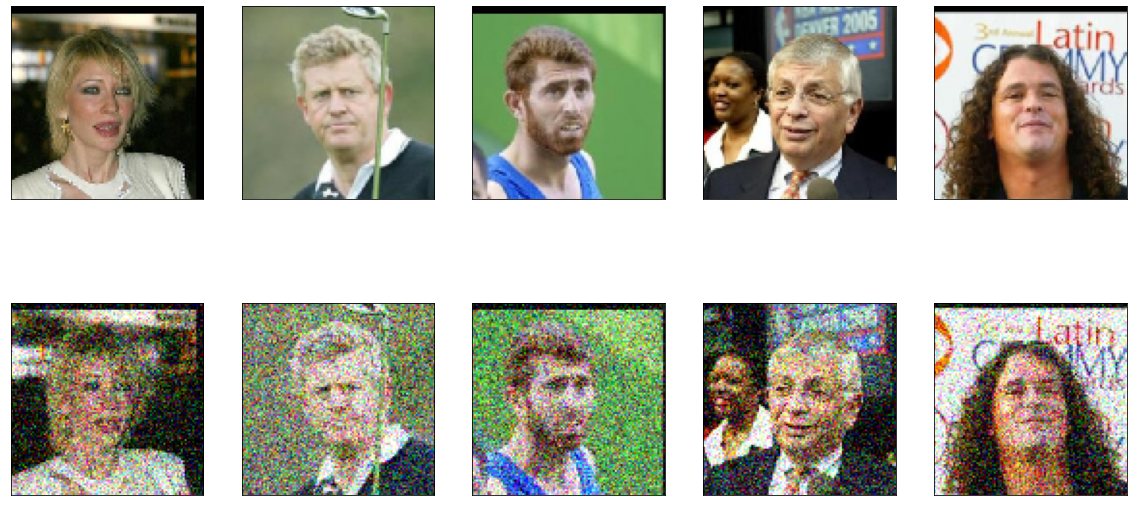

In [5]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(x_val_noisy[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

**5.3 Autoencoder Model**

In [6]:
Input_img = Input(shape=(100, 100, 3))

x1 = Conv2D(256,(3,3), activation='relu',padding='same')(Input_img)
x2 = Conv2D(128,(3,3), activation='relu',padding='same')(x1)
x2 = MaxPool2D((2,2))(x2)
encoded = Conv2D(64,(3,3), activation='relu', padding='same')(x2)

x3 = Conv2D(64,(3,3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2,2))(x3)
x4 = Conv2D(128,(3,3), activation='relu', padding='same')(x3)
x5 = Conv2D(256,(3,3), activation='relu', padding='same')(x4)

decoded = Conv2D(3,(3,3), padding='same')(x5)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

2022-02-17 11:33:19.441842: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-17 11:33:19.442467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 256)     7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 128)     295040    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)   

In [7]:
# กำหนด Encoder Architecture

epoch = 2
batch_size = 8
early_stopper = EarlyStopping(monitor="val_loss")

history = autoencoder.fit(  x_train_noisy,
                            train_x,
                            batch_size=batch_size,
                            epochs=epoch,
                            shuffle=True,
                            validation_data=(x_val_noisy,val_x),
                            callbacks=[early_stopper])

2022-02-17 11:35:56.635816: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/2


2022-02-17 11:35:57.072903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - ETA: 0s - loss: 0.0162

2022-02-17 11:37:04.241161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - 75s 373ms/step - loss: 0.0162 - val_loss: 0.0040
Epoch 2/2
197/197 [==============================] - 82s 415ms/step - loss: 0.0036 - val_loss: 0.0032


In [8]:
predictions_val = autoencoder.predict(x_val_noisy)
predictions_test = autoencoder.predict(x_test_noisy)

2022-02-17 11:39:05.134276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


<Figure size 1440x720 with 0 Axes>

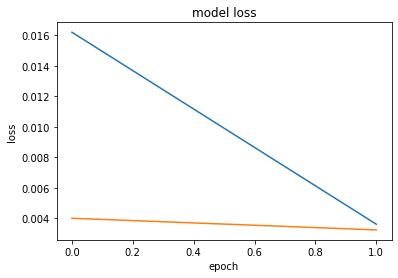

<Figure size 1440x720 with 0 Axes>

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legendn = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

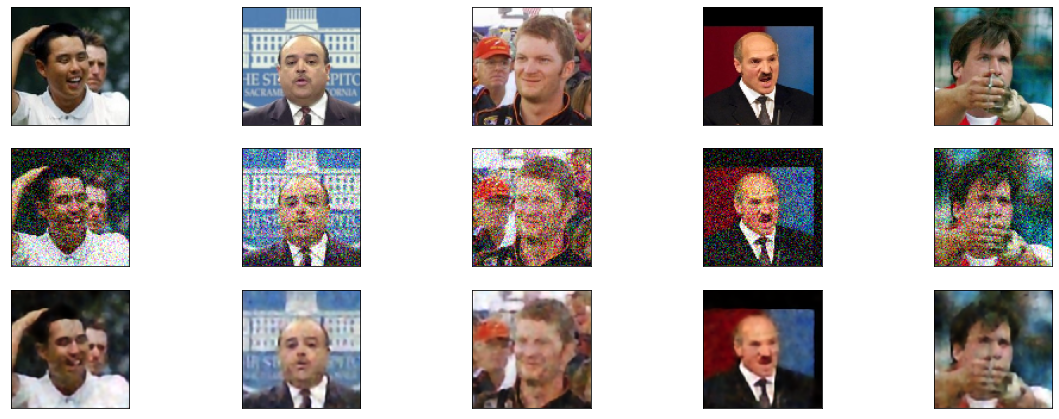

In [11]:
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(4, n, i+1)
  plt.imshow(test_x[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(4, n, i+1+n)
  plt.imshow(x_test_noisy[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(4, n, i+1+(2*n))
  plt.imshow(predictions_test[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.savefig('act5_3_pic.png', facecolor="white", transparent=True)
plt.show()